# Static Q-Balls
#### Computation with FastAI

Self-gravitating complex scalar field in flat spacetime with a self-interacting potential, $U(\Psi) = \lambda \left( \Psi^6 - a \Psi^4 + b \Psi^2 \right)$.

*Ansatz*: $\Psi = f(r)e^{i \omega t}$

*Equation of Motion*: $$f'' + \dfrac{2}{r} f' + \omega^2 f - \lambda \left( 6 f^5 - 4 a f^3 + 2 b f \right) = 0 ~,$$ with $f'(0) = 0$ and $f(\infty) = 0$.

*Equation of Motion in compactified coordinate*: $$(1-x)^4 \left( x \dfrac{d^2 f}{dx^2} - 2 \dfrac{df}{dx} \right) + x \omega^2 f - x \lambda \left( 6 f^5 - 4 a f^3 + 2 b f \right) = 0 ~,$$ with $f'(0) = 0$ and $f(1) = 0$.

*Contants of the problem*: $\lambda = 1~,~~a = 2~,~~b = 1.1$

##### Import packages

In [1]:
import torch as torch
import torch.utils.data as D
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

##### Select device

In [2]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
device

device(type='mps')

### Configuration of the problem

In [57]:
# contants of the problem
lmbd = 1
a = 2
b = 1.1
w = 0.9

# Number of radial points
nPoints = 10000

# Number of validation points
nValid = 2000

# Number of training points
nTrain = nPoints-nValid

### Preparation of dataset and dataloaders

In [58]:
# Independent variable
x_data = torch.rand(nPoints,device=device).view(-1,1)

# Targets
# Since we define our loss as the equation of motion, the targets are all zeros
f_data = torch.zeros_like(x_data)

In [59]:
# Dataset with all data
dset_data = D.TensorDataset(x_data,f_data)

In [60]:
# Random Split of the dataset with all data into two for training and validation
dset_train, dset_valid = D.random_split(dset_data,[nTrain,nValid])

In [61]:
# Initializing the dataloaders for the train and valid sets
dl_train = D.DataLoader(dset_train,batch_size=1000,shuffle=True)
dl_valid = D.DataLoader(dset_valid,batch_size=1000,shuffle=False)

### Model

In [62]:
class Simple_net(torch.nn.Module):
  def __init__(self):
    super(Simple_net,self).__init__()
    self.fc1 = nn.Linear(1,100)
    self.fc2 = nn.Linear(100,500)
    self.fc3 = nn.Linear(500,1000)
    self.fc4 = nn.Linear(1000,1)

  def forward(self,x):
    x = F.gelu(self.fc1(x))
    x = F.gelu(self.fc2(x))
    x = F.gelu(self.fc3(x))
    x = self.fc4(x)
    return x

  def reset_weights(self):
    torch.nn.init.kaiming_uniform_(self.fc1.weight)
    torch.nn.init.kaiming_uniform_(self.fc2.weight)
    torch.nn.init.kaiming_uniform_(self.fc3.weight)
    torch.nn.init.kaiming_uniform_(self.fc4.weight)

In [63]:
model = Simple_net()
model.to(device)

Simple_net(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1, bias=True)
)

### Loss Function

In [64]:
def mse_loss_ode(model,x_inp,targets):
  y_out = model(x_inp)

  dy_out = torch.autograd.grad(y_out,x_inp,grad_outputs=torch.ones_like(y_out),create_graph=True, allow_unused=True)[0]
  ddy_out = torch.autograd.grad(dy_out,x_inp,grad_outputs=torch.ones_like(dy_out),create_graph=True, allow_unused=True)[0]

  # Equation of motion: (1-x^4)*(x*d^2f/dx^2 + 2*df/dx) + x*w^2*f - x*lmbd*(6*f**5 - 4*a*f**3 + 2*b*f) = 0
  ODE = (1-x_inp**4)*(x_inp*ddy_out + 2*dy_out) + x_inp*w**2*y_out - x_inp*lmbd*(6*y_out**5 - 4*a*y_out**3 + 2*b*y_out)
  
  # Boundary condition f'(0) = 0
  x_Boundary_0 = torch.tensor([0.0001],device=device)
  x_Boundary_0.requires_grad = True
  y_Boundary_0 = model(x_Boundary_0)
  dy_Boundary_0 = torch.autograd.grad(y_Boundary_0,x_Boundary_0,grad_outputs=torch.ones_like(y_Boundary_0),create_graph=True, allow_unused=True)[0]
  BC1 = dy_Boundary_0
  
  # Boundary condition f(1) = 0
  x_Boundary_1 = torch.tensor([1.],device=device)
  y_Boundary_1 = model(x_Boundary_1)
  BC2 = y_Boundary_1
  
  # Full loss function
  CoefBoundary = 0.01
  LossFunction = ODE + CoefBoundary*(BC1 + BC2)
  
  # Computation of the loss
  loss = F.mse_loss(LossFunction,targets)

  return loss

### Optimizer

In [65]:
opt_func = torch.optim.Adam(model.parameters())
gamma_batches = 10**(6/len(dl_train))  # Optimal gamma value for the Scheduler that will be use on the LRFinder
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt_func, gamma=gamma_batches)

### Learning Rate Finder

In [66]:
losses, lrs = [],[]
opt_func.param_groups[0]['lr'] = 1e-6

model.train()
for inputs, labels in dl_train:
  inputs = inputs.to(device)
  labels = labels.to(device)

  inputs.requires_grad = True

  opt_func.zero_grad()

  outputs = model(inputs)
  loss = mse_loss_ode(model,inputs,labels)
  loss.backward()
  opt_func.step()

  losses.append(loss.item())

  #opt_func.param_groups[0]['lr'] *= 1.2
  scheduler.step()
  lrs.append(opt_func.param_groups[0]['lr'])

  if opt_func.param_groups[0]['lr']>1 or torch.isnan(loss): break

model.reset_weights()

/var/folders/77/23r18kr12290_w0wtd7r_b9c0000gn/T/ipykernel_2340/3284743627.py:4: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,10])


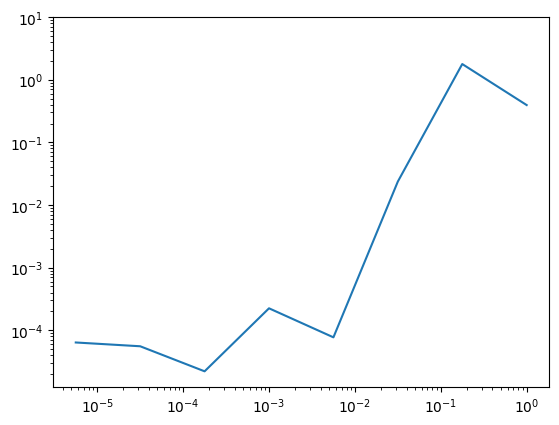

In [67]:
plt.plot(lrs,losses)
plt.xscale('log')
plt.yscale('log')
plt.ylim([0,10])
plt.show()

### Training

In [79]:
opt_func.param_groups[0]['lr'] = 5e-4

In [80]:
n_epochs = 100
train_loss, val_loss = [], []

for epoch in range(n_epochs):

  # Training

  train_loss_batch = 0.

  model.train()
  for inputs, labels in dl_train:
    inputs = inputs.to(device)
    labels = labels.to(device)

    inputs.requires_grad = True

    opt_func.zero_grad()

    outputs = model(inputs)
    loss = mse_loss_ode(model,inputs,labels)
    loss.backward()
    opt_func.step()

    train_loss_batch += loss.item()

  # Validation

  val_loss_batch = 0.

  model.eval()
  for inputs, labels in dl_valid:
    inputs = inputs.to(device)
    labels = labels.to(device)

    inputs.requires_grad = True

    outputs = model(inputs)
    loss = mse_loss_ode(model,inputs,labels)

    val_loss_batch += loss.item()

  train_loss.append(train_loss_batch/len(dl_train))
  val_loss.append(val_loss_batch/len(dl_train))
  print("Epoch: {}    Train Loss: {:.10f}    Val loss: {:.10f}".format(epoch, train_loss[epoch], val_loss[epoch]))

Epoch: 0    Train Loss: 0.0019571489    Val loss: 0.0004784156
Epoch: 1    Train Loss: 0.0019459119    Val loss: 0.0004755897
Epoch: 2    Train Loss: 0.0019266287    Val loss: 0.0004814570
Epoch: 3    Train Loss: 0.0019457100    Val loss: 0.0004856810
Epoch: 4    Train Loss: 0.0019130819    Val loss: 0.0004688268
Epoch: 5    Train Loss: 0.0019018319    Val loss: 0.0004643253
Epoch: 6    Train Loss: 0.0018837537    Val loss: 0.0004582226
Epoch: 7    Train Loss: 0.0018733613    Val loss: 0.0004609918
Epoch: 8    Train Loss: 0.0018533986    Val loss: 0.0004643698
Epoch: 9    Train Loss: 0.0018561132    Val loss: 0.0004818042
Epoch: 10    Train Loss: 0.0019053993    Val loss: 0.0004525325
Epoch: 11    Train Loss: 0.0019823436    Val loss: 0.0004492801
Epoch: 12    Train Loss: 0.0020076813    Val loss: 0.0004457016
Epoch: 13    Train Loss: 0.0020906565    Val loss: 0.0004410037
Epoch: 14    Train Loss: 0.0019407173    Val loss: 0.0004345112
Epoch: 15    Train Loss: 0.0018740017    Val loss:

In [18]:
opt_func.param_groups[0]['lr']

0.001

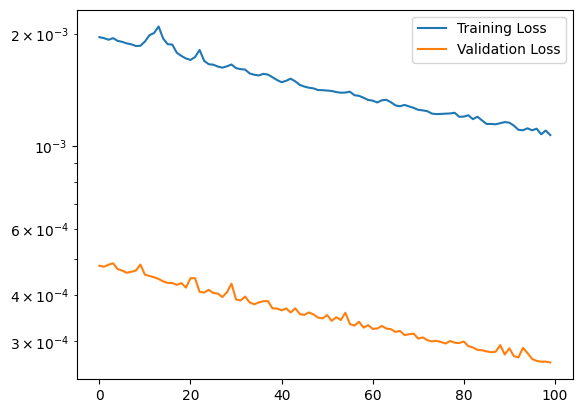

In [81]:
plt.plot(range(n_epochs),train_loss,label='Training Loss')
plt.plot(range(n_epochs),val_loss,label='Validation Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [89]:
x_lin = torch.linspace(0,1,300,device=device).view(-1,1)
f_lin = model(x_lin).detach().cpu()

x_lin = x_lin.cpu()


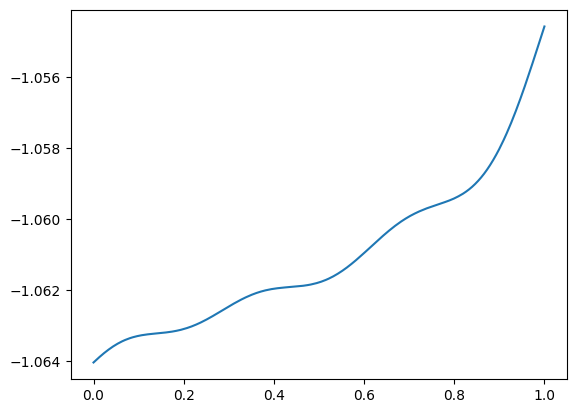

In [90]:
plt.plot(x_lin,f_lin)